In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import Adam
import numpy as np
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
#Transforms
transform =transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomPerspective(0.2, 0.5),
    #transforms.Grayscale(),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5], [0.5])
    #)
])

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 64,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= 32,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:02<00:00, 59633483.71it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


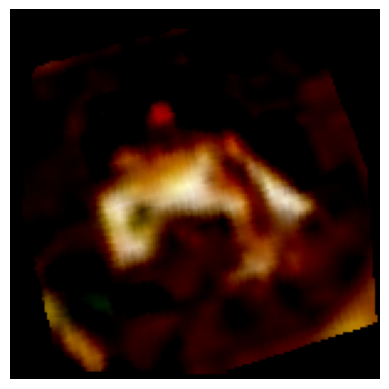

In [ ]:
import matplotlib.pyplot as plt
image, label = next(iter(train_dataset))
image_np = image.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)

# Display the image using matplotlib
plt.imshow(image_np)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

In [ ]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=10,dropout_prob=0.5):
        super(ConvNet,self).__init__()

        #Output size after convolution filter
        #((w-f+2P)/s) +1

        #Input shape= (62,3,150,150)

        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (64,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (64,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (64,12,150,150)

        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (64,12,75,75)


        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (64,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (64,20,75,75)



        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (64,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (64,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (64,32,75,75)
        self.dropout = nn.Dropout(p=dropout_prob)


        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)



        #Feed forwad function

    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)

        output=self.pool(output)

        output=self.conv2(output)
        output=self.relu2(output)

        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        output = self.dropout(output)


            #Above output will be in matrix form, with shape (256,32,75,75)

        output=output.view(-1,32*75*75)


        output=self.fc(output)
        #probabilities = F.softmax(output, dim=1)

        return output

In [ ]:
model=ConvNet(num_classes=10, dropout_prob=0.5).to(device)

In [ ]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [ ]:
num_epochs = 15

for epoch in range(num_epochs):

    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    total_samples=0
    test_accuracies = []

    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())

        optimizer.zero_grad()

        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()


        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        total_samples += labels.size(0)
        train_accuracy+=int(torch.sum(prediction==labels.data))

    train_accuracy=(train_accuracy/total_samples)*100
    train_loss=(train_loss/total_samples)

    model.eval()

    test_accuracy=0.0
    total_samples=0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())

        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        total_samples += labels.size(0)
        test_accuracy += int(torch.sum(prediction == labels.data))
        test_accuracies.append(test_accuracy)



    test_accuracy = (test_accuracy / total_samples) * 100
    variance = np.var(test_accuracies)

    print('Epoch: ' + str(epoch) + ' Train Loss: ' + str(train_loss) + 'Variance: {:.4f}'.format(variance) + ' Train Accuracy: ' + str(train_accuracy) + ' Test Accuracy: ' + str(test_accuracy))

Epoch: 0 Train Loss: tensor(2.7990) Train Accuracy: 35.204 Test Accuracy: 44.529999999999994
Epoch: 1 Train Loss: tensor(1.4887) Train Accuracy: 46.592 Test Accuracy: 49.0
Epoch: 2 Train Loss: tensor(1.3918) Train Accuracy: 50.546 Test Accuracy: 53.23
Epoch: 3 Train Loss: tensor(1.3226) Train Accuracy: 53.086 Test Accuracy: 52.75
Epoch: 4 Train Loss: tensor(1.2765) Train Accuracy: 54.85 Test Accuracy: 56.910000000000004
Epoch: 5 Train Loss: tensor(1.2459) Train Accuracy: 55.916 Test Accuracy: 56.49999999999999
Epoch: 6 Train Loss: tensor(1.2193) Train Accuracy: 56.96 Test Accuracy: 57.14
Epoch: 7 Train Loss: tensor(1.1872) Train Accuracy: 58.192 Test Accuracy: 56.510000000000005
Epoch: 8 Train Loss: tensor(1.1796) Train Accuracy: 58.89 Test Accuracy: 59.48
Epoch: 9 Train Loss: tensor(1.1650) Train Accuracy: 59.18600000000001 Test Accuracy: 59.46
Epoch: 10 Train Loss: tensor(1.1468) Train Accuracy: 59.946 Test Accuracy: 59.77
Epoch: 11 Train Loss: tensor(1.1321) Train Accuracy: 60.3 Tes

In [ ]:
for i, (images, labels) in enumerate(test_loader):
    if i == 0:  # Process only the first batch (which contains 64 images)
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        # Access the first image within the batch (index 0)
        first_image = images[0]
        output = model(first_image.unsqueeze(0))  # Add a batch dimension for the single image
        _, prediction = torch.max(output.data, 1)
        break

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


save_path = '/content/drive/MyDrive/IC_Model/'
torch.save(model.state_dict(), save_path + 'IC_Model.pth')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model = ConvNet(num_classes=10, dropout_prob=0.5).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/CSV Model/IC_Model.pth'))
model.eval()

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=180000, out_features=10, bias=True)
)

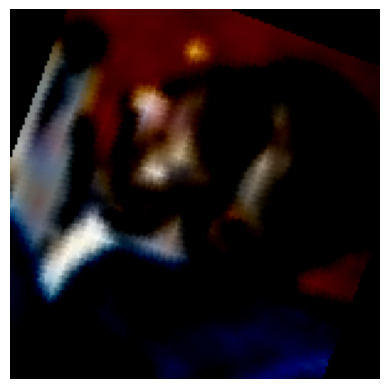

Real label: cat
Model predicted: cat


In [ ]:
import matplotlib.pyplot as plt

# Assuming 'test_loader', 'model', and 'classes' are available
testImage = 0
for i, (images, labels) in enumerate(test_loader):
    if i == testImage:  # Process only the first batch (which contains 64 images)
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        # Access the first image within the batch (index 0)
        first_image = images[0]
        real_label = labels[0].item()  # Get the real label as an integer
        output = model(first_image.unsqueeze(0))  # Add a batch dimension for the single image
        _, prediction = torch.max(output.data, 1)
    if i == testImage:
      break  # Exit the loop after processing the first batch

# Plot the image
plt.imshow(first_image.permute(1, 2, 0).cpu().numpy())  # Convert to CPU and rearrange dimensions
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

# Print the real label and predicted label
real_class = classes[real_label]
predicted_class = classes[prediction[0]]
print(f'Real label: {real_class}')
print(f'Model predicted: {predicted_class}')